In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix as cf
from lime.lime_text import LimeTextExplainer
from helper import *
from IPython.display import display as dp
import IPython
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

torch.set_float32_matmul_precision("medium")
pd.options.mode.chained_assignment = None

### 📖 Modeling Table of Contents

[__1. Model Selection__](#1-model-selection)

[__2. Load Data__](#2-load-data)

[__3. Modeling__](#3-modeling)
- [3.1 Preparation](#31-preparation)
- [3.2 Training](#22-training)

[__4. Compare Baseline Models with Transformer Models__](#4-compare-baseline-models-with-transformer-models)
- [4.1 Heuristic Features Model](#41-heuristic-features-model)
- [4.2 Tfidf Features](#42-tfidfvectorizer-features-model)
- [4.3 Validation Metrics Comparison](#43-validation-metrics-comparison)
- [4.4 Test Prediction Comparison](#44-test-prediction-comparison)

[__5. Error Analysis__](#5-error-analysis)
- [5.1 Use Lime to explain the errors](#51-use-lime-to-explain-the-errors)

[__6. Conclusion__](#6-conclusion)

### 1. Model Selection

__Baseline Model__

We will use two baseline models for this project: one using `heuristic features` \
and another using `TF-IDF features`. As observed during the EDA, TF-IDF features \
are highly predictive (accuracy score: 0.979). This allows us to evaluate whether \
their performance is comparable to more advanced transformer models.

__Transformer Model__

From the EDA, we observed that 75% of all news sequences (titles + text) are shorter \
than 512 tokens, and 97.25% are under 1024 tokens. While extending the sequence \
length to 1024 tokens offers better coverage, it comes at the cost of increased \
memory and computational demands.

Post data cleaning, fake news continues to exhibit more uppercase text, reflecting \
stronger sentiments.

Due to these observations, we aim to explore the impact of `sequence length` and \
`text casing` on transformer models. To evaluate the effect of text casing, we \
utilize both `cased and uncased versions of DistilBERT`. Furthermore, we include \
the `Longformer model`, configured with a maximum token length of 1024, and compare \
its performance to the DistilBERT models, which are limited to 512 tokens.

The primary evaluation metrics for this analysis are `accuracy`, `recall`, and \
`training time`.


### 2. Load Data

In [ ]:
data_dict = joblib.load("data/model_dataset_dict.pkl")

X_train = data_dict["X_train"]
y_train = data_dict["y_train"]
X_val = data_dict["X_val"]
y_val = data_dict["y_val"]
X_test = data_dict["X_test"]
y_test = data_dict["y_test"]
X_demo = data_dict["X_demo"]
y_demo = data_dict["y_demo"]


train_df = data_group_df(X_train, y_train)
val_df = data_group_df(X_val, y_val)
test_df = data_group_df(X_test, y_test)
demo_df = data_group_df(X_demo, y_demo)

dataset_dict = {
    'train': FakeNewsDataset(train_df),
    'val': FakeNewsDataset(val_df),
    'test': FakeNewsDataset(test_df),
    'demo': FakeNewsDataset(demo_df)
}

### 3. Modeling

#### 3.1 Preparation

##### 3.1.1 Calculate class_weight for positive class


In [ ]:
pos_count = sum(y_train)
neg_count = len(y_train) - pos_count
pos_weight = torch.tensor(neg_count / pos_count, dtype=torch.float32)

##### 3.1.2 Initial learning rate suggestion

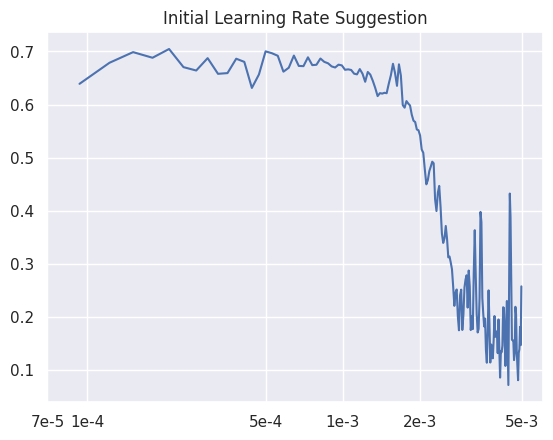

In [ ]:
lr_finder_model = FakeNewsModel()
lr_finder_loader = FakeNewsDataLoader(dataset_dict)

loss_lr_df = initial_lr_finder(model = lr_finder_model, data_loader=lr_finder_loader, batch_size=32)

smoothed_lr = moving_average(loss_lr_df.lr)
smoothed_loss = moving_average(loss_lr_df.loss)
sns.lineplot(x=smoothed_lr, y=smoothed_loss)
plt.xscale("log")
plt.xticks(
    [7e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3],
    ["7e-5", "1e-4", "5e-4", "1e-3", "2e-3", "5e-3"],
)
plt.title("Initial Learning Rate Suggestion")
plt.show()

According to the plot, the suitable learning ranges from 5e-4 ~ 1e-3.

> However, when we experiment with different learning rates during head training, \
we discovered that the learning rate of `1e-4` provides the best results. 

The suggested learning rates led to gradient explosion after several steps.

#### 3.2 Model Training

##### 3.2.1 Head Training

- Only unfreeze the classifier and preclassifier layers.
- Set the learning rate to 1e-4.
- Run for 3 epochs.
- Main metrics: accuracy, recall

Main goals:

1. Compare between `batch_size 32 and batch_size 16` (if difference is not big, \
batch_size 32 is preferred as it trains faster.)
2. Compare between `cased and uncased` models.
3. Compare between `max-token-length 512 (all DistilBERT models) and 1024 (Longformer)`

5 models:
- b16_cased
- b32_cased
- b16_uncased
- b32_uncased
- b16-longformer 


In [ ]:
fakenews_loader = FakeNewsDataLoader(dataset_dict)
fakenews_model_2 = FakeNewsModel(lr=0.0001)

train_head_pipeline(
    dataloader=fakenews_loader, model=fakenews_model_2, model_name="distilbert-0.0001", epoch=3
)

Total train duration: 00 Hours 10 Minutes 18 Seconds seconds.


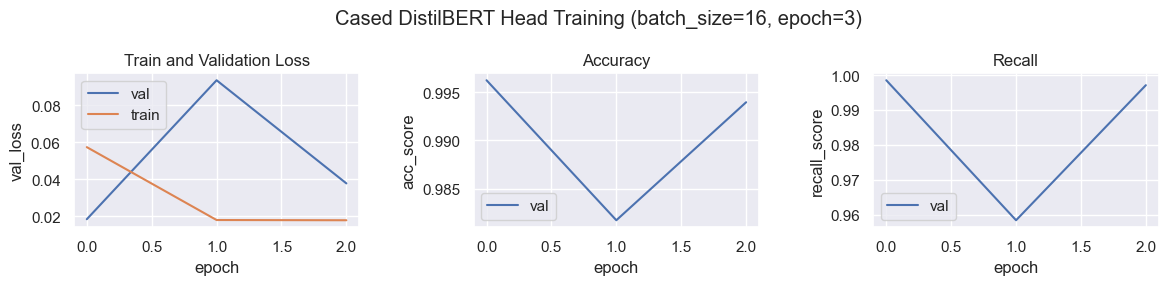

Total train duration: 00 Hours 09 Minutes 39 Seconds seconds.


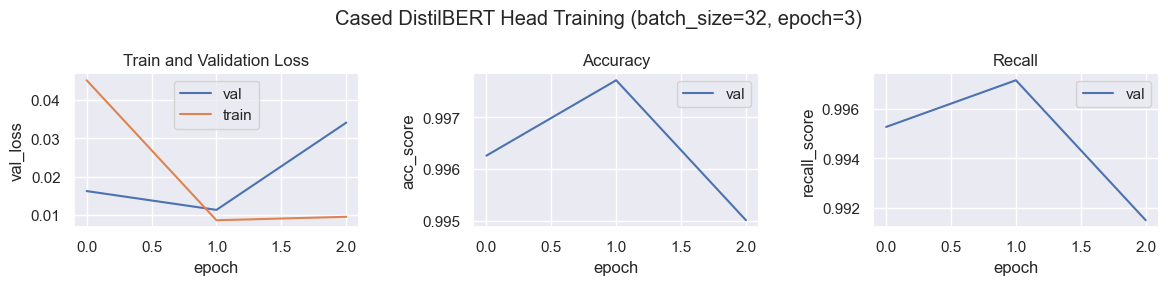

Total train duration: 00 Hours 10 Minutes 16 Seconds seconds.


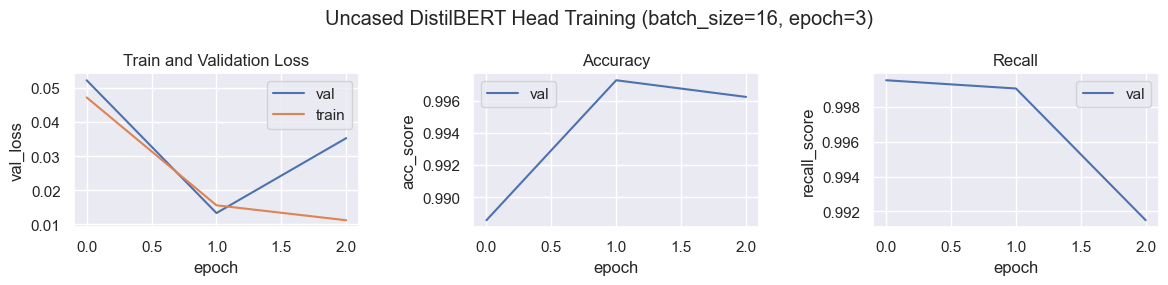

Total train duration: 00 Hours 09 Minutes 40 Seconds seconds.


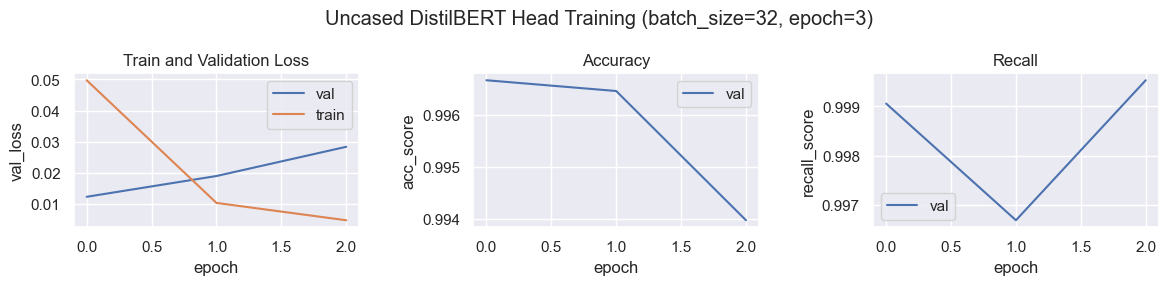

Total train duration: 01 Hours 19 Minutes 48 Seconds seconds.


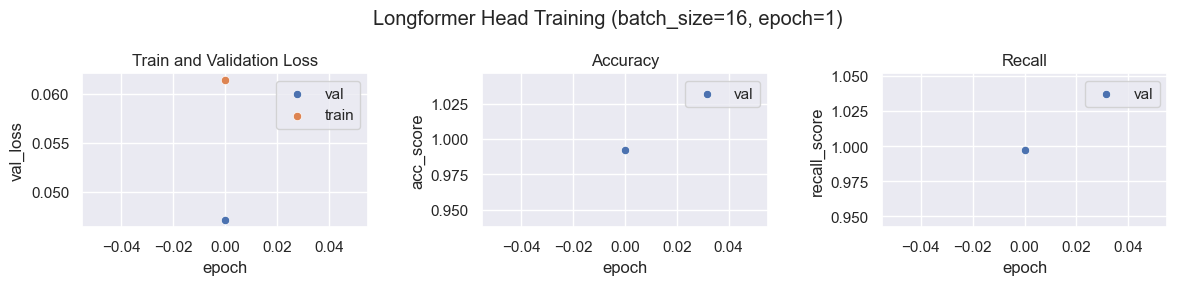

In [ ]:
dis_bert_cased_b16_path = "logs/thu/ht-distilbert-cased-b16/version_1/metrics.csv"
dis_bert_cased_b32_path = "logs/thu/distilbert-0.0001/version_1/metrics.csv"
dis_bert_uncased_b16_path = "logs/thu/distillbert_uncased-0.0001/version_1/metrics.csv"
dis_bert_uncased_b32_path = "logs/thu/ht-distilbert-uncased-b32/metrics.csv"
long_b16_path = "logs/thu/ht-long-b16/version_0/metrics.csv"

dis_bert_cased_b16_head_met = pd.read_csv(dis_bert_cased_b16_path)
dis_bert_cased_b32_head_met = pd.read_csv(dis_bert_cased_b32_path)
dis_bert_uncased_b16_head_met = pd.read_csv(dis_bert_uncased_b16_path)
dis_bert_uncased_b32_head_met = pd.read_csv(dis_bert_uncased_b32_path)
long_b16_head_met = pd.read_csv(long_b16_path)
long_b16_head_met["train_duration"] = 1.33 * 60 * 60

plot_head_met(
    dis_bert_cased_b16_head_met,
    plot_title="Cased DistilBERT Head Training (batch_size=16, epoch=3)",
)

plot_head_met(
    dis_bert_cased_b32_head_met,
    plot_title="Cased DistilBERT Head Training (batch_size=32, epoch=3)",
)


plot_head_met(
    dis_bert_uncased_b16_head_met,
    plot_title="Uncased DistilBERT Head Training (batch_size=16, epoch=3)",
)

plot_head_met(
    dis_bert_uncased_b32_head_met,
    plot_title="Uncased DistilBERT Head Training (batch_size=32, epoch=3)",
)

plot_head_met(
    long_b16_head_met,
    plot_title="Longformer Head Training (batch_size=16, epoch=1)",
    only_one_epoch=True,
)

__Compare Head Train Metrics of Transformer Models__

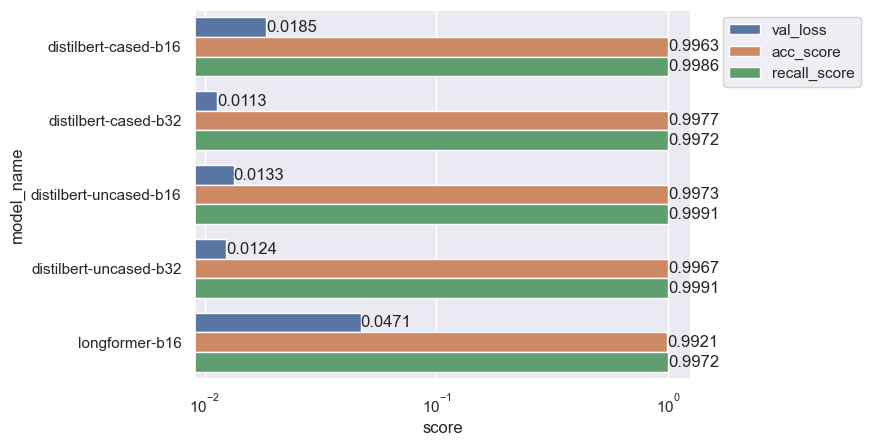

In [ ]:
all_head_met = pd.concat(
    [
        dis_bert_cased_b16_head_met,
        dis_bert_cased_b32_head_met,
        dis_bert_uncased_b16_head_met,
        dis_bert_uncased_b32_head_met,
        long_b16_head_met,
    ]
)

best_epoch_df = (
    all_head_met.query("val_loss < 0.1")
    .sort_values("val_loss")
    .groupby("model_name", as_index=False)
    .first()[["model_name", "val_loss", "acc_score", "recall_score"]]
)
best_epoch_df_plt = best_epoch_df.melt(
    id_vars="model_name",
    value_vars=["val_loss", "acc_score", "recall_score"],
)

ax = sns.barplot(data=best_epoch_df_plt, y="model_name", x="value", hue="variable")
plt.xscale("log")
mark_bar(ax, digit=4)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("score")
plt.show()

__Model Training__

The accuracy and recall metrics among the 4 BERT models are very similar. \
Batch size 32 trains slightly faster than batch size 16, but the difference \
is not very big, training time for 1 epoch ranges from 3m ~ 3.5m.

We don't observe significant metric difference betwen cased and uncased models. \
This indicates that the model can capture the semantics without relying on casing.

The Longformer model has higher validation loss than the BERT models, and \
it takes much longer to train (3 minutes v.s. 133 minutes per epoch).


- Accuracy ranking: 
    1. b32_cased 
    2. b16_uncased
    3. b32_uncased
    4. b16_cased

- Recall ranking: 
    1. b16_cased
    1. b32_uncased
    3. b16_uncased
    4. b32_cased

> We would select `b_32 cased model` for further fine-tuning and prediction \
analysis which has the highest accuracy score.

> Also we would test out `longformer model` in prediction analysis. (We won't \
fine-tune longformer as it takes too long to run).

##### 3.2.2 Fine Tuning

- Unfreeze the entire model
- Lower the learning rate to 1e-5
- Run for 10 epochs

Fine tune `b32_cased model`


In [ ]:
best_head_path = (
    "logs/thu/distilbert-0.0001/version_0/checkpoints/epoch=01-val_loss=0.01.ckpt"
)

best_head_trained_model = FakeNewsModel.load_from_checkpoint(best_head_path)

fine_tune_pipeline(
    dataloader=fakenews_loader, head_trained_model=best_head_trained_model, model_name="ft-distilbert-0.0001", batch_size = 32, epoch=10, lr = 0.00001
)

Total train duration: 31 Minutes 28 Seconds seconds.


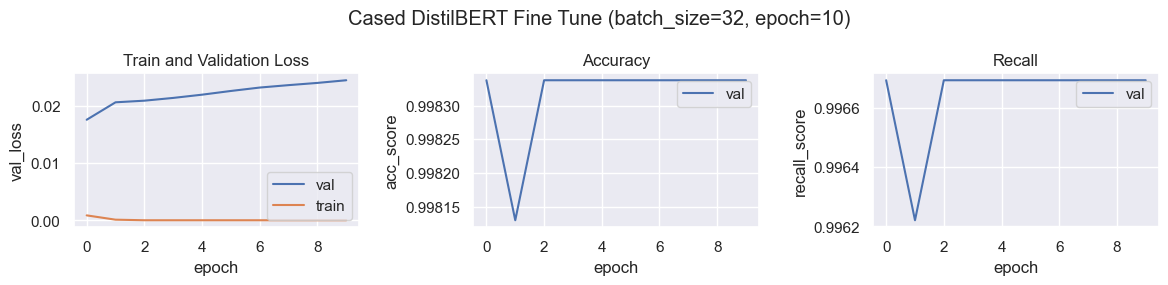

In [226]:
dis_bert_cased_path = "logs/thu/ft-distilbert-0.0001/version_1/metrics.csv"

dis_bert_cased_head_met = pd.read_csv(dis_bert_cased_path)

plot_head_met(
    dis_bert_cased_head_met,
    plot_title="Cased DistilBERT Fine Tune (batch_size=32, epoch=10)",
)

Throughout 10 epochs of fine-tuning, metrics does not improve from the \
head-trained-only model

> Head training alone is sufficient for the transformer to detect fake news.

#### 4. Compare Baseline Models with Transformer Models

Use 2 different baseline models which we've briefly explored in EDA:

- `Heuristic features + GradientBoostingClassifier`

- `TF-IDF features + Logistic Regression`

Hyperparameter tuning is performed to maximize the performance.

##### 4.1 Heuristic Features Model

In [ ]:
fitted_heuristic_model_rs = heuristic_model_rs.fit(X_train, y_train)

best_heuristic_model = fitted_heuristic_model_rs.best_estimator_
best_heuristic_model.fit(X_train, y_train)

train_cv_score = round(
    fitted_heuristic_model_rs.cv_results_["mean_test_score"].mean(), 3
)

y_pred = best_heuristic_model.predict(X_val)
heuristic_val_acc = accuracy_score(y_val, y_pred)
heuristic_val_recall = recall_score(y_val, y_pred)

print("Best Heuristic Model: ")
best_heuristic_model[-1]

Best Heuristic Model: 


GradientBoostingClassifier(n_estimators=50, random_state=0)

##### 4.2 TfidfVectorizer Features Model

In [ ]:
fitted_tfidf_grid = tfidf_grid.fit(X_train, y_train)
tfidf_model = fitted_tfidf_grid.best_estimator_

tfidf_model.fit(X_train, y_train)

tfidf_val_pred = tfidf_model.predict(X_val)

tfidf_acc = accuracy_score(y_val, tfidf_val_pred)
tfidf_recall = recall_score(y_val, tfidf_val_pred)

##### 4.3 Validation Metrics Comparison

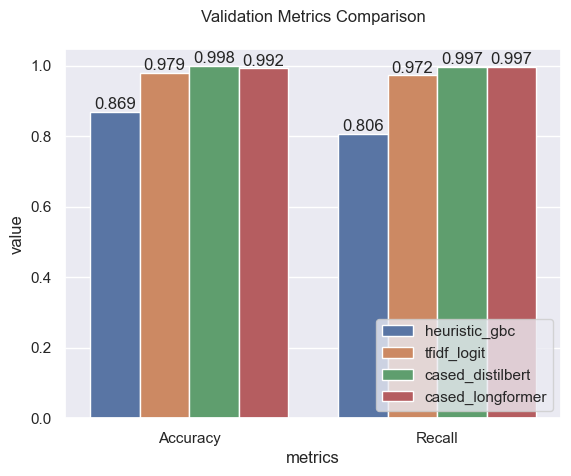

In [291]:
cased_distilbert_best_metrics = dis_bert_cased_head_met.loc[
    dis_bert_cased_head_met.index == 34
]
cased_distilbert_acc = round(cased_distilbert_best_metrics["acc_score"].tolist()[0], 3)
cased_distilbert_recall = round(
    cased_distilbert_best_metrics["recall_score"].tolist()[0], 3
)
longformer_best_metrics = long_b16_head_met.query("val_loss < 1")
longformer_acc = round(longformer_best_metrics["acc_score"].tolist()[0], 3)
longformer_recall = round(longformer_best_metrics["recall_score"].tolist()[0], 3)

model_met_compare_df = pd.DataFrame(index=["Accuracy", "Recall"])

model_met_compare_df["heuristic_gbc"] = [heuristic_val_acc, heuristic_val_recall]

model_met_compare_df["tfidf_logit"] = [tfidf_acc, tfidf_recall]

model_met_compare_df["cased_distilbert"] = [
    cased_distilbert_acc,
    cased_distilbert_recall,
]

model_met_compare_df["cased_longformer"] = [
    longformer_acc,
    longformer_recall,
]

met_plot_df = model_met_compare_df.round(3).reset_index().melt(id_vars="index")

ax = sns.barplot(data=met_plot_df, hue="variable", y="value", x="index")

plt.legend(loc="lower right")
plt.xlabel("score")
plt.xlabel("metrics")
plt.title("Validation Metrics Comparison", y=1.05)
mark_bar(ax, digit=3)

##### 4.4 Test Prediction Comparison

In [ ]:
fakenews_loader = FakeNewsDataLoader(dataset_dict)

best_fine_tuned_path = (
    "logs/thu/ft-distilbert-0.0001/version_1/checkpoints/epoch=00-val_loss=0.02.ckpt"
)

best_fine_tuned_model = FakeNewsModel.load_from_checkpoint(best_fine_tuned_path)

bert_pred_res = prediction_pipeline(dataloader = fakenews_loader, fine_tuned_model = best_fine_tuned_model)

long_pred_res = joblib.load("data/long_pred_res.pkl") # saved from pervious run on GPU

y_true = test_df.label.tolist()
y_pred_probs_bert = [i for t in bert_pred_res for i in t.tolist()]
y_pred_bert = [1 if i > 0.5 else 0 for i in y_pred_probs_bert]

y_pred_probs_long = [i for t in long_pred_res for i in t.tolist()]
y_pred_long = [1 if i > 0.5 else 0 for i in y_pred_probs_long]

X_test_tfidif = clean_and_join_seq_ls_transformer.fit_transform(X_test)
y_pred_tfidif = tfidf_model.predict(X_test_tfidif)

y_pred_heuristic = best_heuristic_model.predict(X_test)

y_true = y_true
y_pred_bert = y_pred_bert
y_pred_long = y_pred_long
y_pred_tfidif = y_pred_tfidif
y_pred_heuristic = y_pred_heuristic

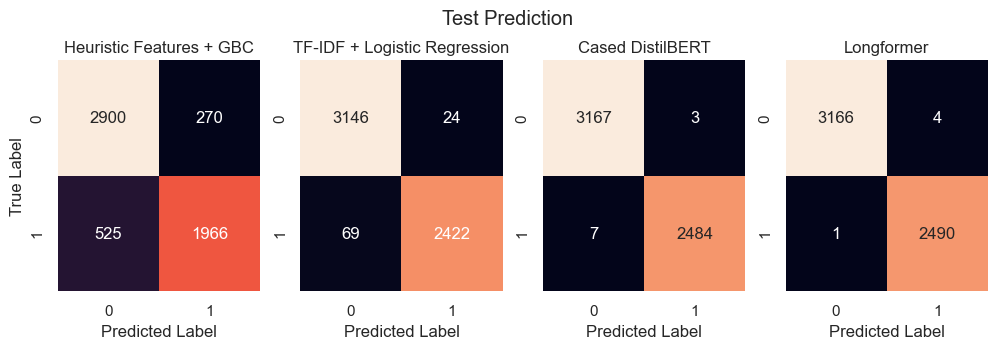

In [294]:
bert_cf = cf(y_true, y_pred)
long_cf = cf(y_true, y_pred_long)
heuristic_cf = cf(y_true, y_pred_heuristic)
tfidf_cf = cf(y_true, y_pred_tfidif)

fig_size(12, 3)

plt.subplot(1, 4, 1)
sns.heatmap(heuristic_cf, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Heuristic Features + GBC")


plt.subplot(1, 4, 2)
sns.heatmap(tfidf_cf, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted Label")
plt.title("TF-IDF + Logistic Regression")

plt.subplot(1, 4, 3)
sns.heatmap(bert_cf, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted Label")
plt.title("Cased DistilBERT")

plt.subplot(1, 4, 4)
sns.heatmap(long_cf, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted Label")
plt.title("Longformer")
plt.suptitle("Test Prediction", y=1.05)
plt.show()

__Baseline Models and Transformer Models Comparison__

Both transformer models outperformed the two baseline models. 

The heuristic model, which relies primarily on structural information and includes \
minimal sentiment data (e.g., punctuations and sentiment analysis), performed \
significantly worse compared to the other three models.

The TF-IDF + GDB/ Logit model demonstrated performance comparable to the \
transformer models. Given its simplicity and speed, it is a strong candidate for \
scenarios with limited computational resources (e.g., no GPU) or when very high \
accuracy is not required (e.g., accuracy > 0.99).

The DistilBERT and Longformer models differ in their maximum sequence lengths. \
Interestingly, during validation, DistilBERT showed better accuracy and recall \
than Longformer, but Longformer produced superior predictions on the test set. \
Possible reasons are: 

- There's more edge cases in test data, since Longformer allows longer token length, \
it is able to capture rarer pattern and generalize better.
- Longformer model has overfitted in validation dataset, but not in test dataset. 
- We only trained for 1 epoch for Longformer, if we trained for more epochs, perhaps \
the model would learn better.

__Which model is the best, why ?__

It depends,

- When computational resources is limited, and when high accuracy (> 0.99) is not \
required, TF-IDF Vectorizer + Logit/ GDB model is a suitable model for fake news \
detection. Apart from this, as TF-IDF is using word frequency as feature, unlike \
transformer models, feature importance and influence can be reasoned very easily.

- With GPU and sufficient memory, DistilBERT model has the best trade-off between \
accuracy and training speed.

- If there's no limitation for computational resources, Longformer model can be \
a very good candidate.

> Overall for our task and resource, DistilBERT model is the most suitable model.

#### 5. Error Analysis

Perform error analysis on Cased DistilBERT model.

In [ ]:
distilbert_errors = [i for i in range(0, len(y_true)) if y_true[i] != y_pred[i]]
distilbert_errors_texts = test_df.iloc[distilbert_errors, :].text.tolist()
print(f"Total test size: {test_df.shape[0]}")
print(f"Misclassified samples count: {len(distilbert_errors)}")
dp(test_df.iloc[distilbert_errors, :])

Total test size: 5661
Misclassified samples count: 10


text  label
619   gao opens door for congress to review leverage...      0
833   alert, flood of cubans breeze across texas bor...      1
1818  priceless, watch bill clinton defend hillary’s...      1
2031  energy department to close office of internati...      1
2034  state-by-state poll closing times for u.s. ele...      0
3098  trump tells state department to make cut more ...      1
3527  guantanamo shrinking but obama goal of closing...      0
4274  iranian navy fires warning shots on and seizes...      1
5117  putin calls out obama for arming and training ...      1
5339  every american should be concerned about what ...      1

__Use Lime to explain the errors__

There's 10 errors in total, below we show some representative false positive and \
false negative errors.

In [ ]:
# clear cache
torch.cuda.empty_cache()

best_fine_tuned_path = (
    "logs/thu/distilbert-0.0001/version_1/checkpoints/epoch=01-val_loss=0.01.ckpt"
)
best_fine_tuned_model = FakeNewsModel.load_from_checkpoint(best_fine_tuned_path)
fakenews_loader = FakeNewsDataLoader(dataset_dict)

# set up lime explainer
class_names = ["real", "fake"]
explainer = LimeTextExplainer(class_names=class_names)

__False Negative Samples__

In [ ]:
# example 1
error_sample = distilbert_errors[2]
torch.cuda.empty_cache()
explanation = explainer.explain_instance(error_sample, lime_predictor, num_features=10, num_samples=800)
explanation.show_in_notebook(text=error_sample)
explanation.show_in_notebook(text=error_sample)

# example 2
error_sample = distilbert_errors[-3]
torch.cuda.empty_cache()
explanation = explainer.explain_instance(error_sample, lime_predictor, num_features=10, num_samples=800)
explanation.show_in_notebook(text=error_sample)

explanation.show_in_notebook(text=error_sample)

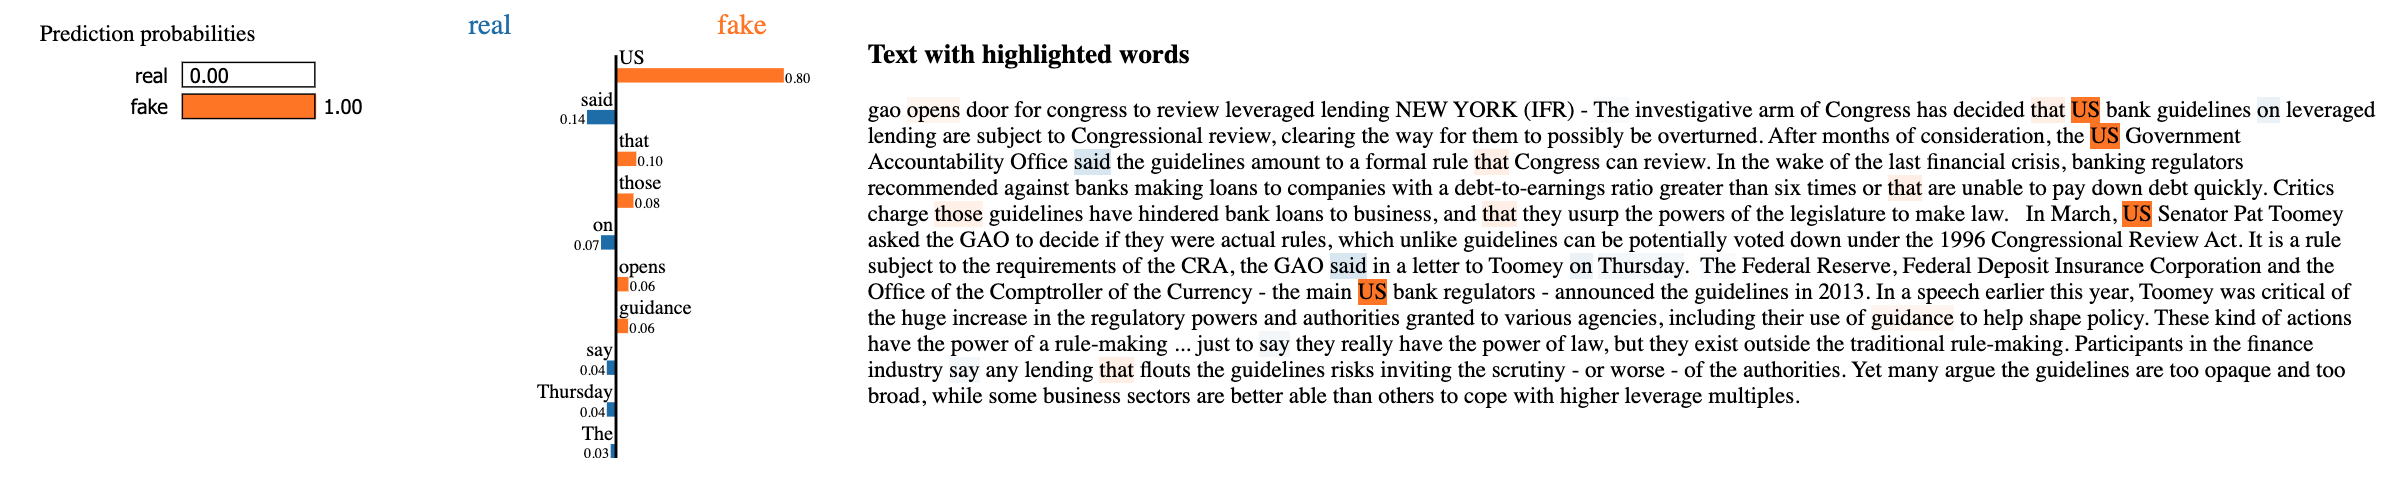

In [23]:
IPython.display.Image("img_data/fn1.png")

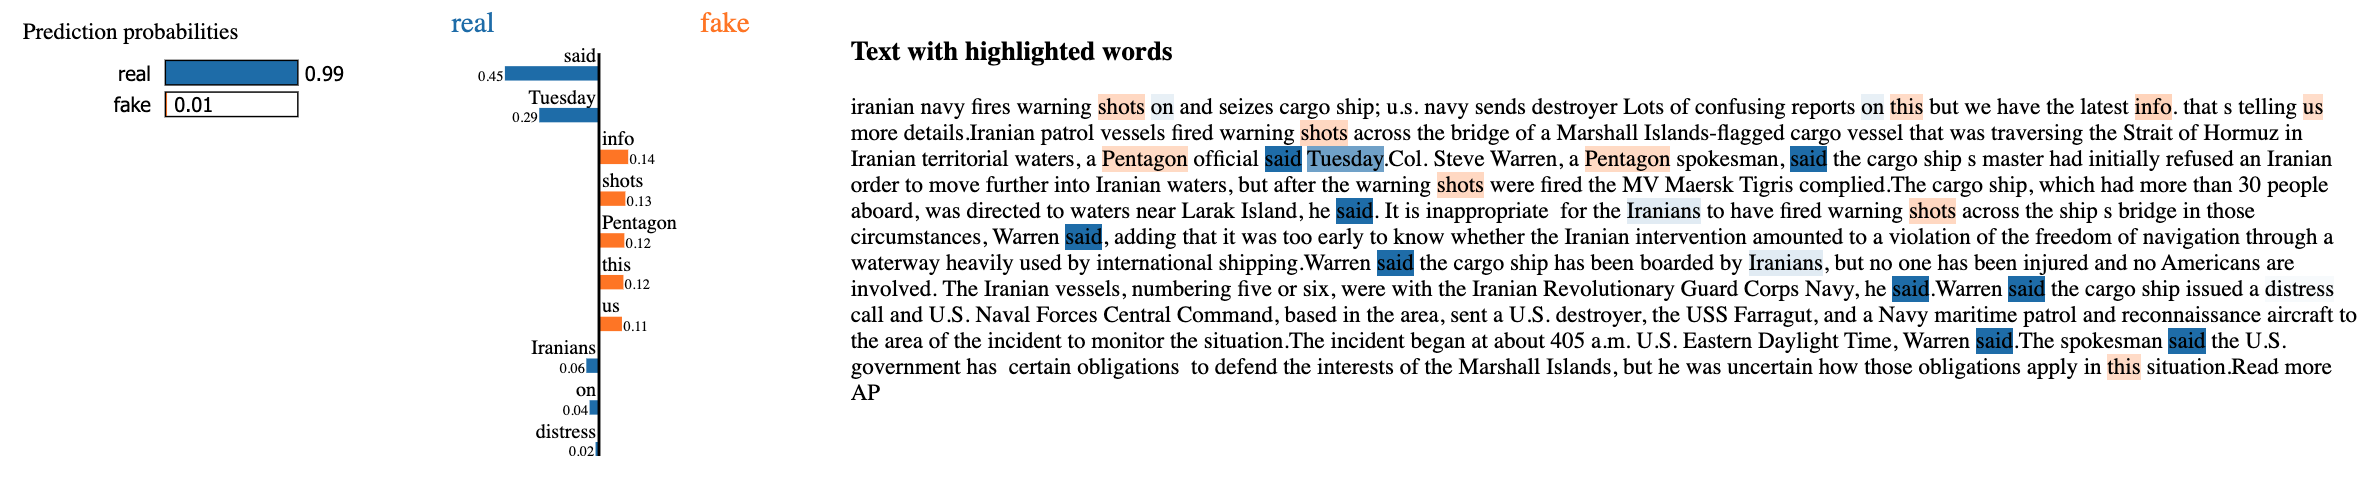

In [24]:
IPython.display.Image("img_data/fn2.png")

__False Positive Samples__

In [ ]:
# example 1
error_sample = distilbert_errors[0]
torch.cuda.empty_cache()
explanation = explainer.explain_instance(error_sample, lime_predictor, num_features=10, num_samples=800)
explanation.show_in_notebook(text=error_sample)

# example 2
error_sample = distilbert_errors[4]
torch.cuda.empty_cache()
explanation = explainer.explain_instance(error_sample, lime_predictor, num_features=10, num_samples=800)
explanation.show_in_notebook(text=error_sample)

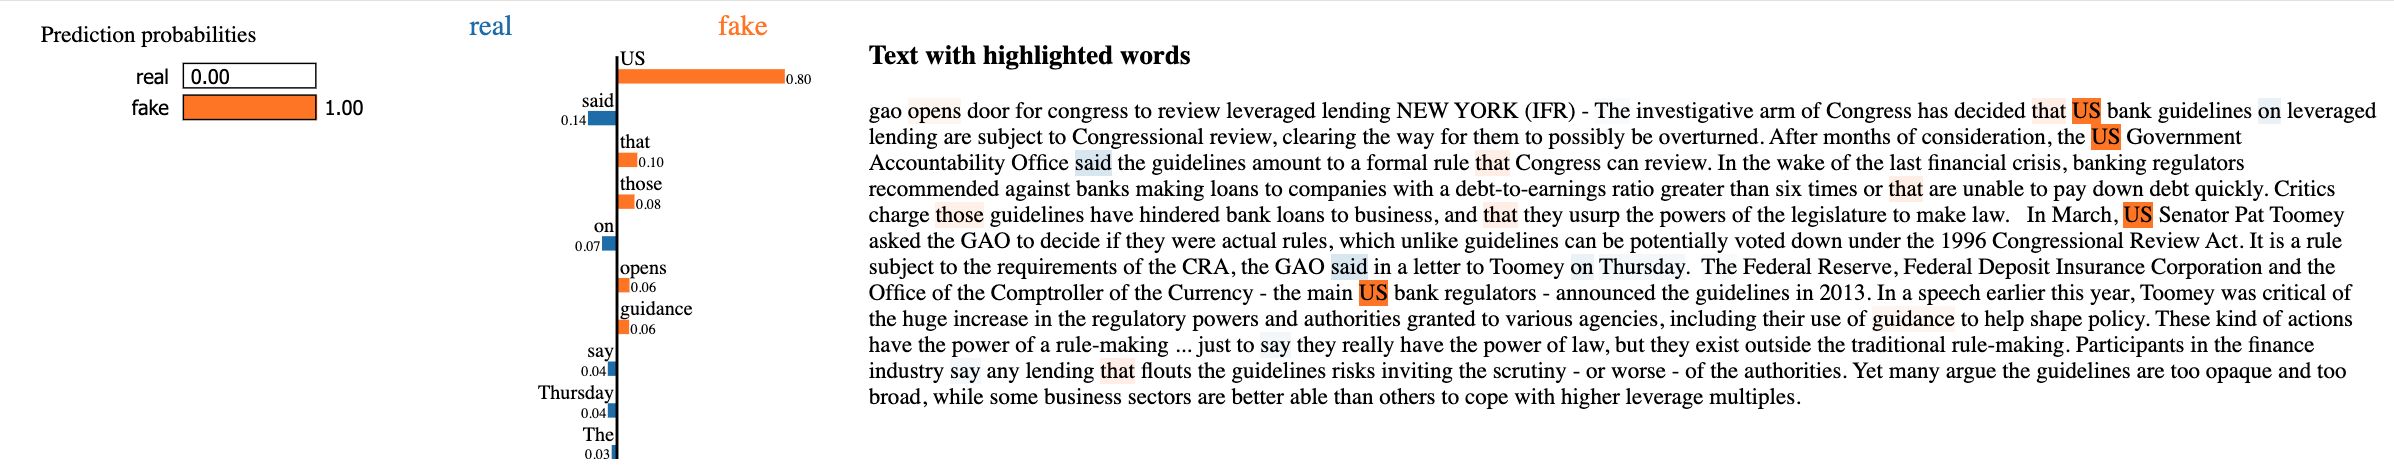

In [21]:
IPython.display.Image("img_data/fp1.png")

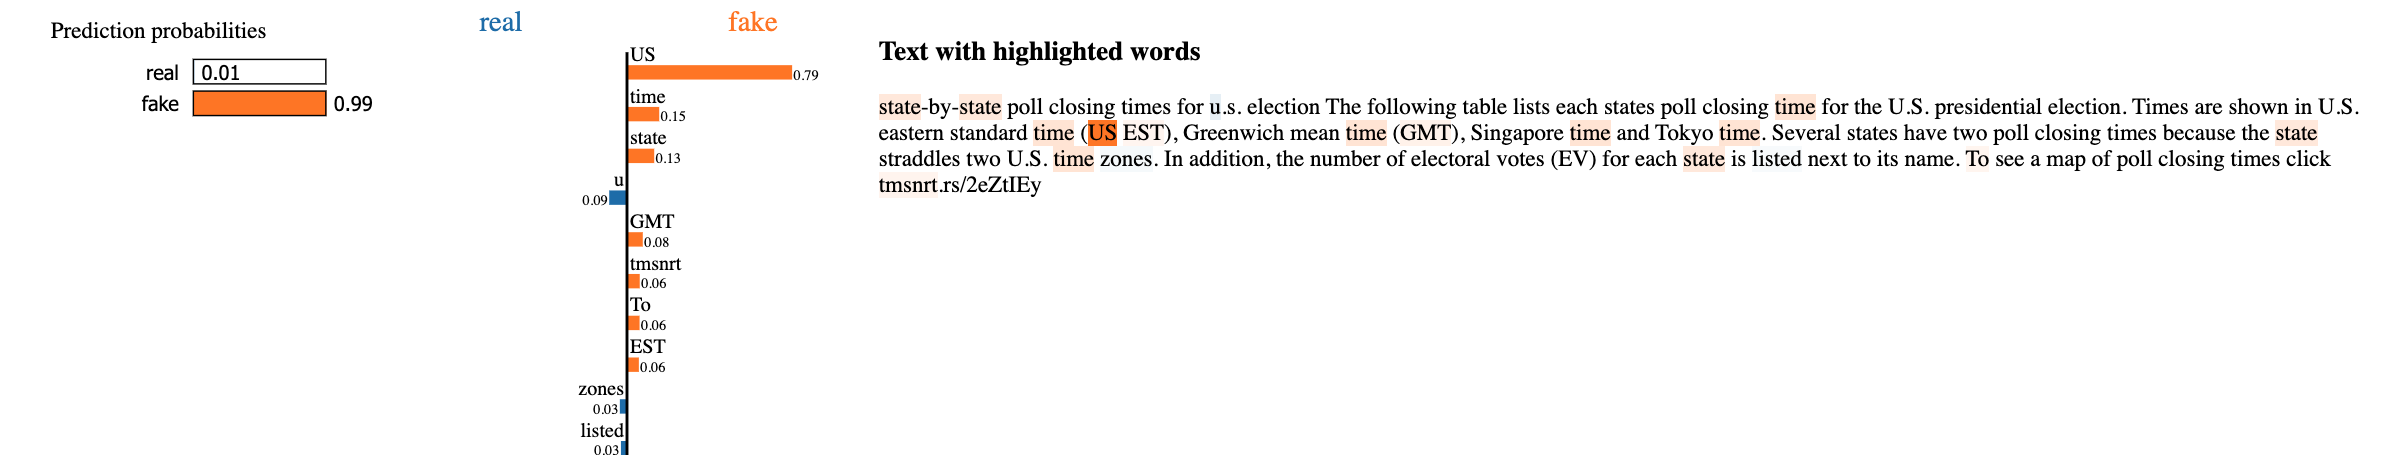

In [22]:
IPython.display.Image("img_data/fp2.png")

__Error Analysis__

The error explanations provided by the Lime explainer align with previous findings. \
False negatives frequently include words like said, weekdays (e.g., Thu, Tue), \
and Clinton, while false positives often contain words like US and state.

However, some problematic tokens were identified, such as:

- `u.s.` being splitted into `u` and `s`, 
- `hiliary's` being splitted into `hiliary` and `s`

In these cases, the token `s` carries entirely different semantics, potentially \
confusing the model. Improved preprocessing could help prevent the generation \
of such ambiguous tokens.

Additionally, the last false positive error sample presented here is not truly news. \
It has an unusually high frequency of the token `time` and should have been \
excluded during data cleaning.

#### 6. Conclusion

In this notebook, we trained three transformer models—cased and uncased DistilBERT, \
and Longformer—and compared them against baseline models using TF-IDF word frequency \
features and heuristic features.

When configured appropriately, the cased and uncased DistilBERT models achieved \
identical accuracy (>99%), suggesting that fine-tuning is unnecessary for this \
task. DistilBERT effectively learns word semantics independent of casing. Since 97% \
of sequences are under 1024 tokens, we also trained a Longformer model. While its \
metrics were comparable to the DistilBERT models, its training time was 40 times \
longer, making it suboptimal for this task. However, for tasks requiring coverage \
of longer sequences, Longformer would outperform lower sequence-coverage models \
like DistilBERT.

Interestingly, the TF-IDF model performed only 2–3% worse than the transformer \
models. Although transformers generate embeddings differently by leveraging complex \
attention mechanisms, this result implies that distinctive word frequency accounts \
for 97% of the classification performance, with the remaining 2–3% improvement \
attributed to the transformers' attention mechanism.